In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cpu" 

In [2]:
def generate_pinwheel(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/Formulator/Spiral/blob/master/PyTorch_Spiral_DataLoader.ipynb
    D = 2 # dimensionality
    K = 3 # number of classes
    N = num // K  # note: we will not generate exactly num datapoints unless K divides num
    X = np.zeros((N*K,D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + rng.standard_normal(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    return X

def generate_spiral(*, num: int, rng: np.random.Generator) -> np.ndarray:
    thetas = rng.uniform(low=0.0, high=6*np.pi, size=(num,))
    rs = thetas * 0.05
    X = np.hstack((
        (rs * np.cos(thetas))[:, None],
        (rs * np.sin(thetas))[:, None],
    ))
    X = X + 0.04 * rng.standard_normal(X.shape) 
    return X

def generate_checkerboard(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/malbergo/stochastic-interpolants/blob/main/notebooks/checker-mirror.ipynb
    x1 = rng.uniform(size=num) * 4 - 2
    x2_ = rng.uniform(size=num) - rng.choice([0, 1], size=(num,)) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    x = np.hstack([x1[:, None], x2[:, None]]) * 2
    return x

def generate_gaussian_mixtures(*, num: int, rng: np.random.Generator) -> np.ndarray:
    angles = np.linspace(0, 2*np.pi, 8)[:-1]
    idxs = rng.choice(np.arange(len(angles)), size=num)
    X = np.hstack((
        1.2*np.cos(angles[idxs])[:, None],
        1.2*np.sin(angles[idxs])[:, None]
    ))
    X = X + rng.standard_normal(size=X.shape) * 0.12
    return X

In [3]:
rng = np.random.default_rng()

X_pinwheel = generate_pinwheel(num=2000, rng=rng)

X_spiral = generate_spiral(num=2000, rng=rng)

X_checkerboard = generate_checkerboard(num=2000, rng=rng)

X_gmm = generate_gaussian_mixtures(num=2000, rng=rng)

In [4]:
pinwheel_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_pinwheel)),
    batch_size=128,
    shuffle=True
)

spiral_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_spiral)),
    batch_size=128,
    shuffle=True
)

checkerboard_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_checkerboard)),
    batch_size=128,
    shuffle=True
)

gmm_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_gmm)),
    batch_size=128,
    shuffle=True
)

In [5]:
# ---------- Residual Block ----------
class ResBlock(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, h),
        )
    def forward(self, x):
        return x + self.net(x)

# ---------- VAE Model ----------
class VAE(nn.Module):
    def __init__(self, d=2, h=256, z=2, n_res=3):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(d, h),
            nn.ReLU(),
            nn.LayerNorm(h),
            *[ResBlock(h) for _ in range(n_res)],
        )
        self.fc_mu = nn.Linear(h, z)
        self.fc_logvar = nn.Linear(h, z)

        # Decoder
        self.dec_in = nn.Sequential(
            nn.Linear(z, h),
            nn.ReLU(),
            nn.LayerNorm(h),
        )
        self.decoder = nn.Sequential(
            *[ResBlock(h) for _ in range(n_res)],
            nn.Linear(h, d)  # output is unbounded
        )

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        h = self.dec_in(z)
        return self.decoder(h), mu, logvar

    @torch.no_grad()
    def sample(self, n=2000, device="cpu"):
        z_ = torch.randn(n, self.fc_mu.out_features, device=device)
        h = self.dec_in(z_)
        return self.decoder(h).cpu().numpy()

# ---------- Loss Function ----------
def vae_loss(x, x_recon, mu, logvar, beta=0.2):
    recon = nn.MSELoss(reduction="mean")(x_recon, x)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl

In [6]:
# ---------- Residual Block ----------
class ResBlock(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, h),
        )
    def forward(self, x):
        return x + self.net(x)

# ---------- Generator ----------
class Generator(nn.Module):
    def __init__(self, z=2, h=128, d=2, n_res=2):
        super().__init__()
        self.z_dim = z
        
        self.input = nn.Sequential(
            nn.Linear(z, h),
            nn.ReLU(),
            nn.LayerNorm(h)
        )
        self.body = nn.Sequential(*[ResBlock(h) for _ in range(n_res)])
        self.output = nn.Linear(h, d)

    def forward(self, z):
        h = self.input(z)
        h = self.body(h)
        return self.output(h)

# ---------- Discriminator ----------
class Discriminator(nn.Module):
    def __init__(self, d=2, h=128, n_res=2):
        super().__init__()
        self.input = nn.Sequential(
            nn.Linear(d, h),
            nn.ReLU(),
            nn.LayerNorm(h)
        )
        self.body = nn.Sequential(*[ResBlock(h) for _ in range(n_res)])
        self.output = nn.Sequential(
            nn.Linear(h, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.input(x)
        h = self.body(h)
        return self.output(h)

# ---------- Sampling function ----------
@torch.no_grad()
def sample_gan(G, n=2000, device="cpu"):
    z = torch.randn(n, 2, device=device)
    return G(z).cpu().numpy()


In [7]:
def train_vae(loader, X, epochs=1500):
    print("\nTraining VAE...")
    
    # Initialize model and optimizer
    vae = VAE(d=2, h=128, z=24, n_res=3).to(device)
    opt = optim.Adam(vae.parameters(), lr=1e-3)
    
    for _ in tqdm(range(epochs), desc="Epochs"):
        for (x,) in loader:
            x = x.to(device).float()
            opt.zero_grad()
            x_recon, mu, logvar = vae(x)
            loss = vae_loss(x, x_recon, mu, logvar, beta=0.2)
            loss.backward()
            opt.step()
    
    # Generate samples from the trained VAE
    vae.eval()
    vae_samples = vae.sample(n=2000, device=device)
    
    
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], s=2, alpha=0.2)
    plt.scatter(vae_samples[:,0], vae_samples[:,1], s=3)
    plt.title(f"VAE")
    plt.show()

In [8]:
def train_gan(loader, X, epochs=1500):
    print("\nTraining GAN...")
    
    # Initialize models
    G = Generator(z=2, h=128, d=2, n_res=2).to(device)
    D = Discriminator(d=2, h=128, n_res=2).to(device)
    
    optG = optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.9))
    optD = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.9))
    
    bce = nn.BCELoss()
    
    for _ in tqdm(range(epochs), desc="Epochs"):
        for (x,) in loader:
            x = x.to(device).float()
            bs = x.size(0)
    
            # ---------------------
            # Train Discriminator
            # ---------------------
            z = torch.randn(bs, 2, device=device)
            fake = G(z)
    
            optD.zero_grad()
            loss_real = bce(D(x), torch.ones(bs, 1, device=device))
            loss_fake = bce(D(fake.detach()), torch.zeros(bs, 1, device=device))
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optD.step()
    
            # ---------------------
            # Train Generator
            # ---------------------
            optG.zero_grad()
            loss_G = bce(D(fake), torch.ones(bs, 1, device=device))
            loss_G.backward()
            optG.step()
    
    # Sample from trained GAN
    G.eval()
    gan_samples = sample_gan(G, n=2000, device=device)
    
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], s=2, alpha=0.2)
    plt.scatter(gan_samples[:,0], gan_samples[:,1], s=3)
    plt.title(f"GAN")
    plt.show()


Training VAE...


Epochs: 100%|███████████████████████████████| 1500/1500 [01:28<00:00, 16.95it/s]


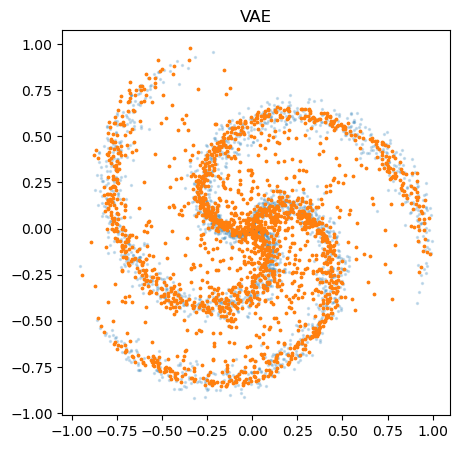


Training GAN...


Epochs: 100%|███████████████████████████████| 1500/1500 [01:29<00:00, 16.75it/s]


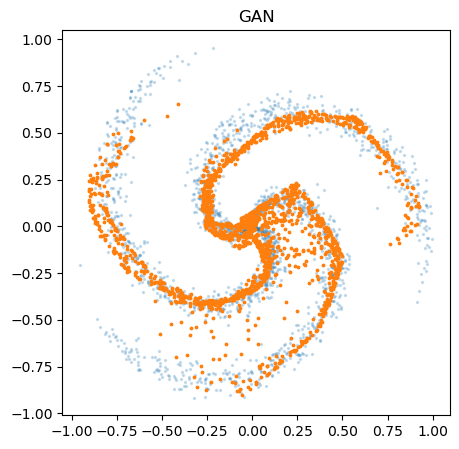

In [9]:
train_vae(pinwheel_loader, X_pinwheel, epochs=1500)
train_gan(pinwheel_loader, X_pinwheel, epochs=1500)


Training VAE...


Epochs: 100%|███████████████████████████████████| 15/15 [00:00<00:00, 15.99it/s]


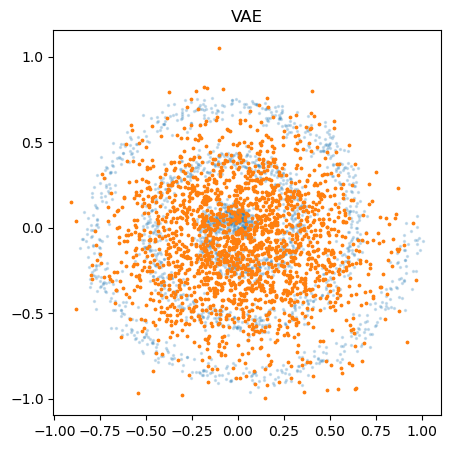


Training GAN...


Epochs: 100%|███████████████████████████████| 1500/1500 [01:27<00:00, 17.05it/s]


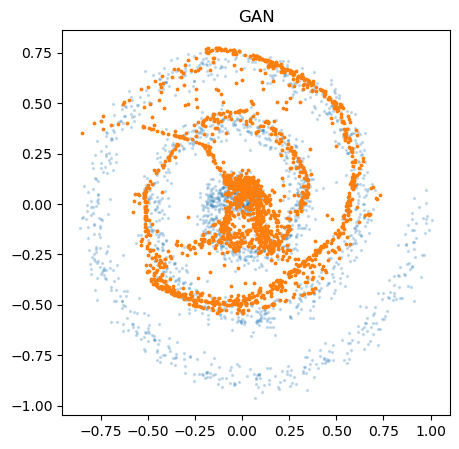

In [10]:
train_vae(spiral_loader, X_spiral, epochs=15)
train_gan(spiral_loader, X_spiral, epochs=1500)


Training VAE...


Epochs: 100%|███████████████████████████████| 1500/1500 [01:26<00:00, 17.34it/s]


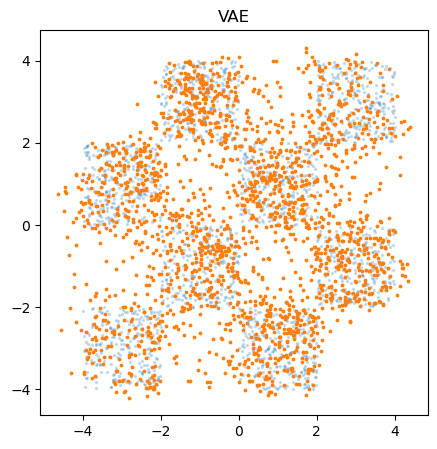


Training GAN...


Epochs: 100%|███████████████████████████████| 1500/1500 [01:28<00:00, 16.88it/s]


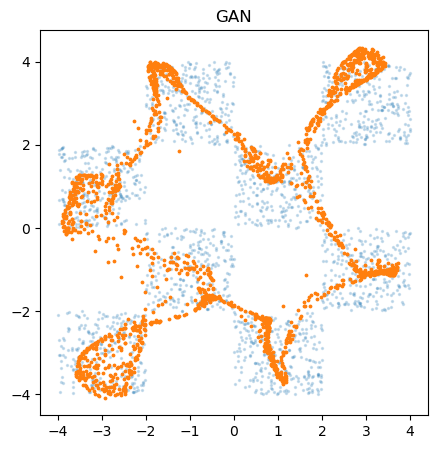

In [11]:
train_vae(checkerboard_loader, X_checkerboard, epochs=1500)
train_gan(checkerboard_loader, X_checkerboard, epochs=1500)


Training VAE...


Epochs: 100%|███████████████████████████████| 1500/1500 [01:31<00:00, 16.39it/s]


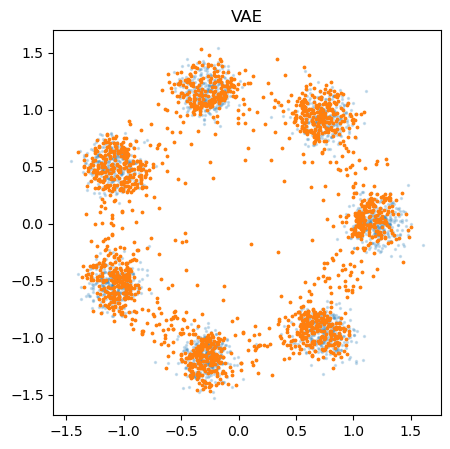


Training GAN...


Epochs:  20%|██████▎                         | 294/1500 [00:17<01:11, 16.90it/s]

In [ ]:
train_vae(gmm_loader, X_gmm, epochs=1500)
train_gan(gmm_loader, X_gmm, epochs=1500)